In [15]:
# Extend your environment with the following packages, if not already installed. The PyTorch Version of your choice is also required.
# ! pip install bigearthnet_patch_interface bigearthnet_common faiss matplotlib timm lmdb

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import faiss

from src.BEN_DataModule_LMDB_Encoder import BENDataSet
from src.BEN_lmdb_utils import valid_labels_classification


/data/mamba_envs/hackstein/conssl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction

In this notebook, we exemplify the procedure of using search by image methods to enrich and create datasets. We create two auxiliary datasets based on BigEarthNet-MM (BEN), where the first one is denoted as _base-dataset_ and contains ~7500 images of Serbia during summer time and the second one is denoted _archive-dataset_ and contains ~65000 images obtained during summer time. The aim of this notebook is to demonstrate the usage of search by image methods to add underrepresented samples to the base-dataset by querying and retrieving images in the archive-dataset.

## 1. Datasets

First, we instantiate the base-dataset and archive-dataset.

In [2]:
# NOTE 'root_dir' is expected to be a directory with a file called 'BigEarthNetEncoded.lmdb'
# root_dir = ''

base_ds = BENDataSet(
    root_dir=root_dir,
    split_dir="./src",
    split='serbia-summer-train',
)

archive_ds = BENDataSet(
    root_dir=root_dir,
    split_dir="./src",
    split='summer-train',
)

base_loader = DataLoader(base_ds, batch_size=256, shuffle=True, drop_last=False)
archive_loader = DataLoader(archive_ds, batch_size=256, shuffle=True, drop_last=False)



Loading BEN data for serbia-summer-train...
Read split from ./src/serbia-summer-train.csv
    7761 patches indexed
    7761 filtered patches indexed
Loading BEN data for summer-train...
Read split from ./src/summer-train.csv
    65599 patches indexed
    65599 filtered patches indexed


In [3]:
# NOTE: Make sure to select a suitable device. Since we use the model to convert two datasets into hashcodes, it is recommended to use a GPU.
# dev = "cuda:0"  
# dev = "cpu"  

## 2. Convert datasets into hash-codes

Here, we load our CSMAE network and load the weights.

In [4]:
from src.model import Network
backbone = Network()

# NOTE ckpt_path is expected to be a path to the weights.ckpt file, as previously delivered via TUB-Cloud
# ckpt_path = ''

state = torch.load(ckpt_path, map_location="cpu")["state_dict"]
ret = backbone.load_state_dict(state, strict=False)
print(f"Loaded ckpt: {ret}")


Loaded ckpt: <All keys matched successfully>


Upon successful instantiation of the model, we convert all samples from both the base-dataset and the archive-dataset to hashcodes by feeding them to our model and obtaining the corresponding hashcodes. For this demo, we consider the modality of Sentinel-2 (S2) and thus call `get_s2_hash()`.

In [5]:
backbone.eval()
backbone.to(dev)

def get_features_lists(backbone: Network, data_loader, dev):

    print(f"Process {len(data_loader)} batches")

    target_list = []
    feat_list_s2 = []
    
    for _, X, y in tqdm.tqdm(data_loader):
        X, y = X.to(dev), y
        
        out = backbone.get_s2_hash(X)
        features_s2 = out

        feat_list_s2.append(features_s2.cpu().detach().numpy().astype(np.int8))
        target_list.append(y.numpy())

    feat_list_s2 = np.concatenate(feat_list_s2)
    target_list = np.concatenate(target_list)

    print("Feature shape", feat_list_s2.shape, feat_list_s2.dtype)
    print("Target shape", target_list.shape)

    return feat_list_s2, target_list


# features (hashcodes) from base-dataset / archive-dataset
with torch.no_grad():
    base_features, base_labels = get_features_lists(backbone, base_loader, dev)
    archive_features, archive_labels = get_features_lists(backbone, archive_loader, dev)


Process 31 batches


100%|██████████| 31/31 [00:20<00:00,  1.52it/s]


Feature shape (7761, 128) int8
Target shape (7761, 19)
Process 257 batches


100%|██████████| 257/257 [02:46<00:00,  1.55it/s]

Feature shape (65599, 128) int8
Target shape (65599, 19)


## 3. Analysis of base-dataset

Let us first inspect the base-dataset by plotting a histogram of label distribution.

In [6]:
labels_categorical = np.ravel([np.nonzero(label) for label in base_labels])

# a helper function to flatten nested lists (used to unpack list of label-lists)
def flatten(xss):
    return np.array([x for xs in xss for x in xs])

labels_list = flatten(labels_categorical)

/data/mamba_envs/hackstein/conssl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


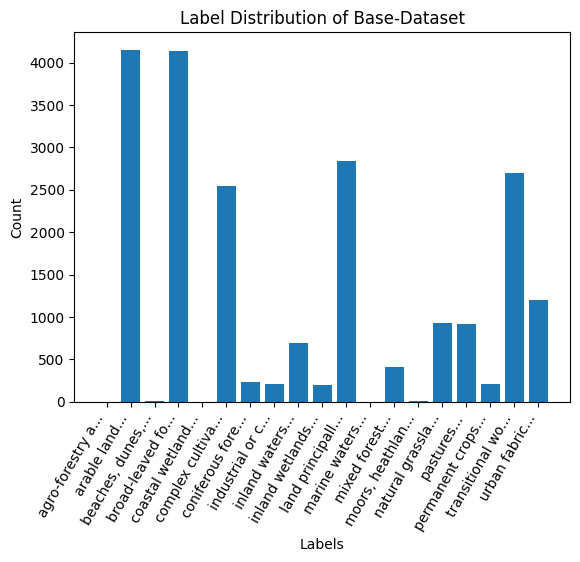

In [7]:
# Calculate the number of unique values
old_unique_values, old_counts = np.unique(labels_list, return_counts=True)
old_unique_values, old_counts = old_unique_values.tolist(), old_counts.tolist()

# Make sure that all 19 labels are included, even if their count is 0
for i in range(19):
    if i not in old_unique_values:
        old_unique_values.insert(i, i)
        old_counts.insert(i, 0)

label_names = [valid_labels_classification[x][:15] + "..." for x in old_unique_values]

plt.bar(label_names, old_counts)
plt.xticks(rotation=60, ha='right')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Label Distribution of Base-Dataset")
plt.show()

We observe that the base-dataset is not balanced as some labels are occuring more often that others. Some labels, e.g. marine waters, are not occuring at all. 

We now select images containing labels that are found to be underrepresented following the previous histogram on label distribution. In particular, we target images containing _marine waters_, _inland wetlands_, _mixed forest_ and _coniferous forest_. Accordingly, we select representatives in our archive-dataset. Finding representatives is done by manual search.

In [8]:
indices = [54224, 3450, 30116, 8013, 43682, 7560]
imgs_list = []

for idx in indices:
    _, img, one_hot_label = archive_ds.__getitem__(idx)
    
    imgs_list.append(img)

    categorical_label = np.nonzero(one_hot_label)
    print(f"Add image with labels: {[valid_labels_classification[x] for x in categorical_label]}")

imgs = np.stack(imgs_list)

Add image with labels: ['marine waters']
Add image with labels: ['marine waters']
Add image with labels: ['beaches, dunes, sands', 'coniferous forest', 'marine waters', 'mixed forest']
Add image with labels: ['beaches, dunes, sands', 'land principally occupied by agriculture, with significant areas of natural vegetation', 'marine waters', 'pastures']
Add image with labels: ['complex cultivation patterns', 'coniferous forest', 'inland waters']
Add image with labels: ['coniferous forest', 'land principally occupied by agriculture, with significant areas of natural vegetation', 'moors, heathland and sclerophyllous vegetation', 'transitional woodland, shrub']


The selected images with labels that are supposed to be added to the base-dataset are converted to tensors first, and then to hashcodes by using the previously instantiated model.

In [9]:
# convert underrepresented images to hash codes
batch = torch.from_numpy(imgs.copy()).to(dev).to(torch.float)
h = backbone.get_s2_hash(batch)
query = h.detach().cpu().numpy()
print("Query hashcodes of shape:", query.shape)


Query hashcodes of shape: (6, 128)


## 4. Image-Retrieval

We use the FAISS library to retrieve top-750 similar images to our queries. To this end, the FAISS Index is instantiated and the archive features are added. Then, we call the `search()` function to retrieve top-750 indices for samples that are closest to their respective query image. Since some indices may be duplicates, we discard them by using the numpy `unique()` function. `ids_list` now contains indices for sets `archive_features` and `archive_labels` (the archive-dataset). The indices point to samples in the archive-dataset that contain labels which are underrepresented in the base-dataset.

In [10]:
# find images that contain these labels
k = 750
embed_dim = archive_features.shape[1]
index = faiss.IndexFlatL2(embed_dim)

index.add(archive_features)

# Retrieve k-closest ids
topk_dists_list, topk_ids_list = index.search(query, k)
print('topk_ids_list', topk_ids_list.shape)

ids_list = np.unique(np.ravel(topk_ids_list))
print('unique ids', ids_list.shape)

topk_ids_list (6, 750)
unique ids (4250,)


By using the IDs of samples in the archive-dataset, we enrich the base-dataset by adding the retrieved samples. We observe, that indeed the labels  _marine waters_, _inland wetlands_, _mixed forest_ and _coniferous forest_ are now more populated while other labels remain at their previous count or slightly increase. Note that due to the nature of multi-label datasets, the increase of labels that are not contained in the query set is expected.

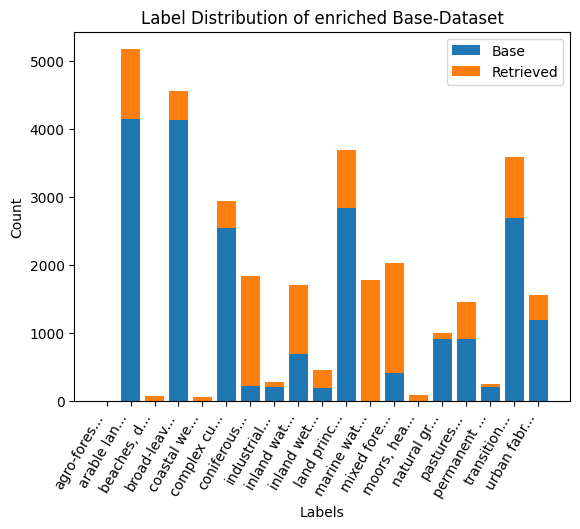

In [11]:
new_samples, new_labels = archive_features[ids_list], archive_labels[ids_list]
new_labels_categorical = np.ravel([np.nonzero(label) for label in new_labels])
new_labels_list = flatten(new_labels_categorical)

# Calculate the number of unique values
new_unique_values, new_counts = np.unique(new_labels_list, return_counts=True)
new_unique_values, new_counts = new_unique_values.tolist(), new_counts.tolist()

for i in range(19):
    if i not in new_unique_values:
        new_unique_values.insert(i, i)
        new_counts.insert(i, 0)

new_label_names = [valid_labels_classification[x][:10] + "..." for x in new_unique_values]

p1 = plt.bar(new_label_names, old_counts)
p2 = plt.bar(new_label_names, new_counts, bottom=old_counts)
plt.legend((p1[0], p2[0]), ('Base', 'Retrieved'))
plt.xticks(rotation=60, ha='right')
plt.title("Label Distribution of enriched Base-Dataset")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## 5. Conclusion

In this notebook, we enriched a base-dataset by retrieving underrepresented samples from an archive-dataset. This procedure can also be used to create datasets. In this case, the base-dataset consists of a small number of curated images which serve as label (class) representatives. By retrieving $k$ similar images for all samples in the base-dataset, a new dataset can be composed. However, it is worth noting that samples in the field of Remote Sensing commonly contain several classes, e.g., beaches and marine waters, which may result in slight imbalances of the overall class population.